# Online Retail

In this notebook, I will use the [dataset](https://www.kaggle.com/mashlyn/online-retail-ii-uci) to build an unsupervised machine learning model which allows one to estimate if a given customer will buy something again from the online shop in the next quarter. 

<a id="problem-statements"></a>
## Problem Statements 

As part of the main problem that will be tackled in this notebook, I will discuss in section named 

1. How many online customers are there in the dataset and what is their country of origin?

2. What are the countries that are most represented in the dataset?

3. Calculate the revenue that was made in each month and what is the percentage revenue based on the various countries?

<a id="toc"></a>
## Table of Contents

* [ ] [<font color=blue>Importing Relevant Python Packages</font>](#importing-relevant-python-packages)
[comment]: <> (Something)
* [ ] [<font color=blue>Importing Relevant Data</font>](#importing-relevant-data)
[comment]: <> (Something)
* [ ] [<font color=blue>Data Engineering</font>](#data-engineering)
    * [<font color=blue>Exploration Question 1</font>](#exp-qxn-1)
    * [<font color=blue>Exploration Question 2</font>](#exp-qxn-2)
    * [<font color=blue>Exploration Question 3</font>](#exp-qxn-3)
    * [<font color=blue>Predicting Customer Purchase</font>](#predicting-customer-purchase)
[comment]: <> (Something) 
* [ ] [<font color=blue>Building Machine Learning Models</font>](#building-machine-learning-models)
[comment]: <> (Something)
* [ ] [<font color=blue>Conclusion</font>](#conclusion)

<a id="importing-relevant-python-packages"></a>
## Importing Relevant Python Packages

In [1]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

<a id='importing-relevant-data'></a>
## Importing Relevant Data

In [2]:
# Loading the data
df = pd.read_csv('online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


<a id='data-engineering'></a>
## Data Engineering

In this section, we will explore the given dataset to answer some general questions about the dataset. This will lead to cause us to introduce other features into the dataset which will help us to build a machine learning model that will help us to answer our main question.

Let's update the pandas dataframe `df` by renaming some of its columns.

In [3]:
# Rename the following columns: 
#    Invoice to InvoiceNo
#    Customer ID to CustomerID
#    Price to UnitPrice

df.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


We can check information about the dataframe with the `info` method. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   InvoiceNo    1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   UnitPrice    1067371 non-null  float64
 6   CustomerID   824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


From the output of the `info` method, we can see that the __CustomerID__ and __Description__  columns are likely to have missing values. Also we may want to change the data type of the objects in the __InvoiceDate__ column to proper date objects with the `to_datetime` method. 

Let's count the number of missing values in each column of the dataframe.

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64

As predicted, the columns __CustomerID__ and __Description__ have $243007$ and $4382$ missing data respectively. The missing data in the __CustomerID__ column represents $22.77\%$ of the entire online customers. 

In [6]:
np.round(df.isnull().sum()["CustomerID"]/df.InvoiceNo.shape[0] * 100, 2)

22.77

How do we deal with these missing data? After talking to the company leaders, they suggested that the item that has a missing __CustomerID__ should be assigned to the id of the customer that frequently purchased that item. In addition, if the value of the `Country` column of the user with missing `CustomerID` is _'Unspecified'_, then update it with the country that the replaced customer has made most of their purchases. The remaining missing data should be deleted. Thus for the remaining onces, we will drop using the `dropna` method.

In [7]:
# Get the dataframe with missing CustomerID
nan_cid_df = df.loc[df.CustomerID[df.CustomerID.isnull()].index]
nan_cid_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [8]:
# Order the CustomerID and Description to get a count of the number of times a customer purchased an item
cid_des_df = df.groupby(['CustomerID', 'Description']).count().reset_index().sort_values(by="InvoiceNo", ascending=False)
cid_des_df.head()

,CustomerID,Description,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country
215480,14911.0,CARRIAGE,149,149,149,149,149,149
464812,17850.0,WOODEN FRAME ANTIQUE WHITE,129,129,129,129,129,129
464810,17850.0,WOOD 2 DRAWER CABINET WHITE FINISH,128,128,128,128,128,128
464811,17850.0,WOOD S/3 CABINET ANT WHITE FINISH,124,124,124,124,124,124
464813,17850.0,WOODEN PICTURE FRAME WHITE FINISH,122,122,122,122,122,122


In [9]:
# Get the description of each iten in the dataframe nan_cid_df
nan_cid_des = nan_cid_df.Description.values

In [10]:
# Note that this takes long when running on a machine with low memory
# for each `item` and `index` in zip(nan_cid_des, nan_cid_df.index.values)
start = time.time()
for item, idx in zip(nan_cid_des, nan_cid_df.index.values):
    try:
        # Get the CustomerID of the customer that has purchased `item` the most.
        cid = cid_des_df.loc[cid_des_df['Description'] == item].head(1).CustomerID.values[0]
        # Update the dataframe `df` with the CustomerID `cid` at the index idx that initially had missing CustomerID
        df.at[idx, "CustomerID"] = cid
        # If the country in the row idx in `df` is Unspecified
        if df.loc[idx]["Country"] == "Unspecified":
            # Replace it with the country that the cid has made most of their purchases.
            cntry = df[df.CustomerID == cid].groupby("Country").count().sort_values(by="InvoiceDate", 
                                                                                    ascending=False).index.values[0]
            # Update the country of `cid` at the index idx with cntry in the dataframe `df`
            df.at[idx, "Country"] = cntry
    except:
        pass
print('Time for running the code in this cell: ', time.time() - start)

Time for running the code in this cell:  6777.3712611198425


Let us now check how many missing data there are in the __CustomerID__ column of our updated dataframe `df`.

In [11]:
print("The updated main dataframe now has {} missing data representing \
{}% of the online customers.".format(df.isnull().sum()["CustomerID"], 
                                     np.round(df.isnull().sum()["CustomerID"]/df.InvoiceNo.shape[0] * 100, 2)))

The updated main dataframe now has 6132 missing data representing 0.57% of the online customers.


In [12]:
df_data = df.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061239 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   InvoiceNo    1061239 non-null  object 
 1   StockCode    1061239 non-null  object 
 2   Description  1061239 non-null  object 
 3   Quantity     1061239 non-null  int64  
 4   InvoiceDate  1061239 non-null  object 
 5   UnitPrice    1061239 non-null  float64
 6   CustomerID   1061239 non-null  float64
 7   Country      1061239 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 72.9+ MB


Next, we update the dataframe `df_data` by converting the date field, __InvoiceDate__ to _datetime_ object. One can use the `to_datetime` method to achieve this.

In [13]:
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
pd.DataFrame(df_data.InvoiceDate.describe())

,InvoiceDate
count,1061239
unique,44296
top,2010-12-06 16:57:00
freq,1346
first,2009-12-01 07:45:00
last,2011-12-09 12:50:00


From the above, we see that the online purchases made by customers was from 2009-12-01  to 2011-12-09.

In the subsequent cells, we will answer some questions we would like to know from the given dataset.

<a id='exp-qxn-1'></a>
### Exploration Question 1
> How many online customers are there in the dataset and what is their country of origin?

In [15]:
print('From the dataset, the online retail shop has {} customers \
from {} different countries.'.format(len(df_data.CustomerID.unique()), len(df_data.Country.unique())))

From the dataset, the online retail shop has 5942 customers from 43 different countries.


<a id='exp-qxn-2'></a>
### Exploration Question 2
> What are the countries that are most represented in the dataset?

In [16]:
ctm_cntry_df = df_data.groupby(['CustomerID', 'Country']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('Country')['CustomerID'].count().reset_index().sort_values(
    by=['CustomerID'], ascending=False)

# Create a new column, Percentage to calculate the customer representation in percentage
ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.CustomerID / ctm_cntry_df.CustomerID.sum() * 100, 2)

ctm_cntry_df.head(10)

,Country,CustomerID,Percentage
40,United Kingdom,5456,83.41
11,EIRE,191,2.92
14,France,139,2.13
15,Germany,107,1.64
30,Portugal,73,1.12
17,Hong Kong,71,1.09
36,Switzerland,65,0.99
34,Spain,41,0.63
39,United Arab Emirates,41,0.63
2,Bahrain,38,0.58


The output above, shows the top $10$ countries of that purchase from the online retail shop with the _United Kingdom_ being the country with the highest customers. They represent about $83.41\%$ of the entire online customers. 

Although $13$ online customers indicated that they were living in two countries, this does not significantly affect the values percetage values recorded. For these $13$ online customers, it may be that the countries recorded for their last purchases is where they are currently living.

In [17]:
# Initialise a dict object. This is supposed to collect all customers who indicated more than 1 country
ctm_2_cntry = {} 

# for each index and customer id
for idx, cid in enumerate(df_data.CustomerID.unique()):
    
    # Get the country that the customer resides
    cntry = df_data[df_data.CustomerID == cid].Country.unique()
    
    # if customer has lived in more than 1 country
    if len(cntry) > 1: 
        
        # Update the ctm_2_cntry
        ctm_2_cntry[cid] = cntry

pd.DataFrame(ctm_2_cntry) # Create a pandas dataframe using ctm_2_cntry

ValueError: arrays must all be same length

In the two next cells, we group countries with customer percentage value less than or equal to $0.25$ together and then plot a pie chart. 

In [20]:
ctm_2_cntry

{13078.0: array(['United Kingdom', 'EIRE'], dtype=object),
 18102.0: array(['United Kingdom', 'Bahrain', 'EIRE'], dtype=object),
 12682.0: array(['France', 'United Kingdom', 'Sweden', 'Hong Kong',
        'United Arab Emirates', 'Lebanon', 'EIRE'], dtype=object),
 17865.0: array(['United Kingdom', 'EIRE'], dtype=object),
 13767.0: array(['United Kingdom', 'EIRE'], dtype=object),
 17238.0: array(['United Kingdom', 'Hong Kong'], dtype=object),
 15311.0: array(['United Kingdom', 'EIRE', 'Bahrain', 'France',
        'United Arab Emirates', 'RSA', 'Portugal', 'Hong Kong',
        'Switzerland'], dtype=object),
 17700.0: array(['United Kingdom', 'Hong Kong'], dtype=object),
 14911.0: array(['EIRE', 'United Kingdom', 'Bahrain', 'United Arab Emirates',
        'Bermuda', 'Hong Kong', 'France', 'Lebanon', 'RSA', 'Portugal',
        'Israel', 'Switzerland'], dtype=object),
 15998.0: array(['United Kingdom', 'France'], dtype=object),
 12931.0: array(['United Kingdom', 'EIRE'], dtype=object),
 147

In [12]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
ctm_cntry_df['CountryCategory'] = ctm_cntry_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

ctm_cntry_df.loc[ctm_cntry_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

ctm_cntry_df.head(11)

,Country,CustomerID,Percentage,CountryCategory
38,United Kingdom,5410,90.85,United Kingdom
14,Germany,107,1.80,Germany
13,France,95,1.60,France
32,Spain,41,0.69,Spain
3,Belgium,29,0.49,Belgium
28,Portugal,24,0.40,Portugal
24,Netherlands,23,0.39,Netherlands
34,Switzerland,22,0.37,Switzerland
33,Sweden,19,0.32,Sweden
18,Italy,17,0.29,Italy


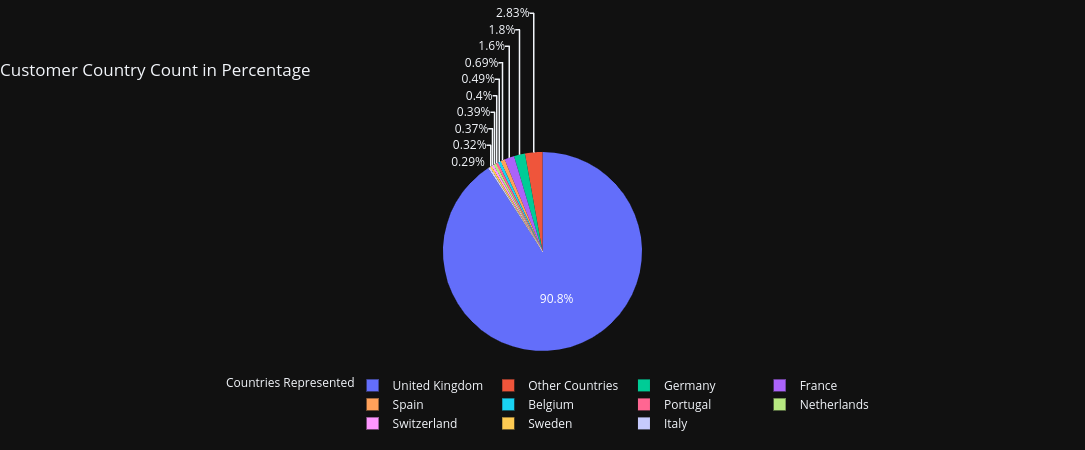

In [90]:
# plot pie chart

pie_fig = px.pie(ctm_cntry_df, 
                 names="CountryCategory", 
                 values="Percentage", 
                 title="Customer Country Count in Percentage", 
                 template= "plotly_dark"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})

<a id='exp-qxn-3'></a>
### Exploration Question 3
> Calculate the revenue that was made in each month and what is the percentage revenue based on countries?

In [14]:
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912


In [15]:
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [16]:
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue.head()

,InvoiceYearMonth,Revenue
0,200912,663272.050
1,201001,531952.902
2,201002,489399.586
3,201003,635996.481
4,201004,560635.022


In [17]:
pd.DataFrame(ctm_revenue.Revenue.describe())

,Revenue
count,2.500000e+01
mean,6.659317e+05
std,2.154966e+05
min,3.425244e+05
25%,5.599246e+05
50%,5.872565e+05
75%,7.810333e+05
max,1.134879e+06


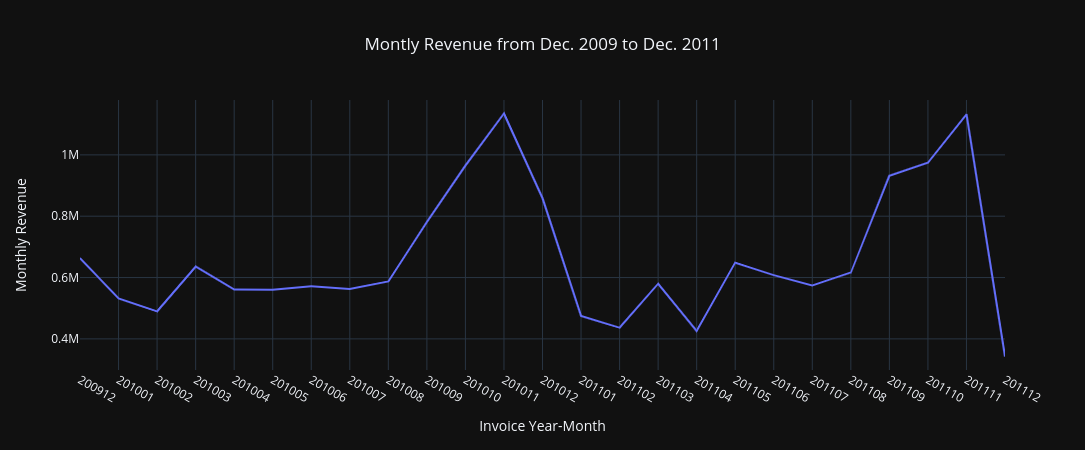

In [18]:
# plot line plot
line_fig = px.line(ctm_revenue, 
                   x = "InvoiceYearMonth", 
                   y = "Revenue", 
                   title = "Montly Revenue from Dec. 2009 to Dec. 2011", 
                   template= "plotly_dark" 
                  )

line_fig.update_layout(title_x=0.5, 
                       showlegend=False, 
                       xaxis={"type": "category"}, 
                       xaxis_title="Invoice Year-Month", 
                       yaxis_title="Monthly Revenue"
                      )

line_fig.show(config={'displaylogo': False})

From the graph figure above, we observe that the online retail shop made the highest sales in November 2010, followed by November 2011. Also, one can observe that, monthly sales rises after August. 

Next, explore the percentage revenue generated by the retail shop based on the countries their customers reside.

In [19]:
cntry_revenue_df = df_data.groupby(['Country']).Revenue.sum().reset_index().sort_values(by=['Revenue'], 
                                                                                        ascending=False)

cntry_revenue_df['Percentage'] = np.round(cntry_revenue_df.Revenue / cntry_revenue_df.Revenue.sum() * 100, 2)

cntry_revenue_df.head(5)

,Country,Revenue,Percentage
38,United Kingdom,1.380642e+07,82.93
10,EIRE,5.785016e+05,3.47
24,Netherlands,5.485250e+05,3.29
14,Germany,4.179886e+05,2.51
13,France,3.265047e+05,1.96


From the output above, the top $5$ countries with respect to revenue generated are:
 * The United Kingdom
 * The Republic of Ireland (EIRE)
 * The Netherlands 
 * Germany 
 * France

with the _United Kingdom_ recording the highest in percentage $(82.93\%)$. 

In the next two cells, we update `cntry_revenue_df` with a new 

In the two next cells, we group countries with revenue percentage value less than or equal to $0.25$ together and then plot a pie chart. 

In [20]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
cntry_revenue_df['CountryCategory'] = cntry_revenue_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

cntry_revenue_df.loc[cntry_revenue_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

cntry_revenue_df.head(11)

,Country,Revenue,Percentage,CountryCategory
38,United Kingdom,1.380642e+07,82.93,United Kingdom
10,EIRE,5.785016e+05,3.47,EIRE
24,Netherlands,5.485250e+05,3.29,Netherlands
14,Germany,4.179886e+05,2.51,Germany
13,France,3.265047e+05,1.96,France
0,Australia,1.671291e+05,1.00,Australia
34,Switzerland,9.908281e+04,0.60,Switzerland
32,Spain,9.185948e+04,0.55,Spain
33,Sweden,8.745542e+04,0.53,Sweden
9,Denmark,6.574109e+04,0.39,Denmark


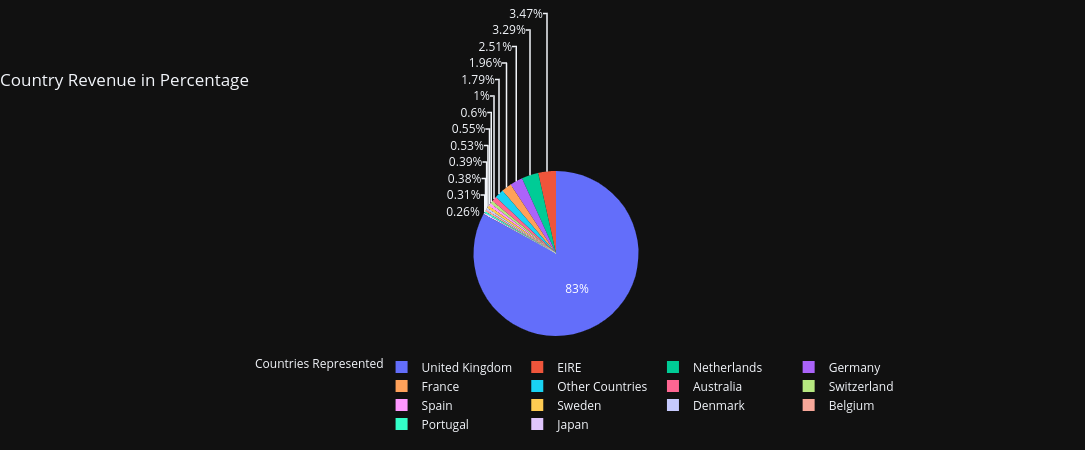

In [91]:
# plot pie chart
pie_fig = px.pie(cntry_revenue_df, 
                 names="CountryCategory", 
                 values="Percentage", 
                 title="Country Revenue in Percentage", 
                 template= "plotly_dark"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Countries Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show(config={'displaylogo': False})

<a id='predicting-customer-purchase'></a>
## Predicting Customer Purchase 

The goal of this section is to come up with a make a model using the given dataframe `df_data`, to estimate if a given customer will buy something again from the online shop in the next quarter. 

The dataframe is split into two. 

* The first sub-dataframe assigned to the Python variable `ctm_bhvr_dt` contains purchases made by customers from `01-12-2009` to `30-08-2011`. This dataframe will be used to study the behavioural purchases of the online customers. 

* The second sub-dataframe assigned to the Python variable `ctm_next_quarter` will be used to study the behavioural purchases of the customers in the next quarter. That is, from `01-09-2011` to `30-11-2011`.

In [22]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


In [23]:
ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [24]:
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())
ctm_dt.columns = ['CustomerID']
ctm_dt.head()

,CustomerID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


Let's find the first purchase made by each customer in the next quarter. 

In [25]:
# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12352.0,2011-09-20 14:34:00
4,12356.0,2011-11-17 08:40:00


Let's find the last purchase made by each customer in the dataframe `ctm_bhvr_dt`.

In [26]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


Let's merge the two dataframes `ctm_last_purchase_bhvr_dt` and `ctm_1st_purchase_in_next_quarter`.

In [27]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:17:00,NaT
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,NaT


Let's calculate the time difference in days between customer's last purchase in the dataframe `ctm_last_purchase_bhvr_dt` and the first purchase in the dataframe `ctm_1st_purchase_in_next_quarter`.

In [28]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00,389.0
4,12350.0,2011-02-02 16:01:00,NaT,NaN


In [29]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,NaN
1,13078.0,13.0
2,15362.0,NaN
3,18102.0,27.0
4,12682.0,15.0


Update the dataframe `ctm_dt` by filling all missing values with $9999$.

In [30]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,9999.0
1,13078.0,13.0
2,15362.0,9999.0
3,18102.0,27.0
4,12682.0,15.0


Next, we will define some features and add them to the dataframe `ctm_dt` to build our machine learning model. We will use the Recency - Frequency - Monetary Value segmentation method. That is, we will put the customers into groups based on the following: 

* __Recency__: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.

* __Frequency__: Customers purchase behaviour based on the number of times they buy from the online retail shop.

* __Monetary Value__/__Revenue__: Customers purchase behaviour based the revenue they generate.

After we will apply *K-means* clustering to assign customers a score to each of the features.

<a id='recency'></a>
#### Recency 

Let's find the most recent purchase date of each customer and see how many days they have been inactive. Afterwards, we can apply *K-means* clustering to assign customers a recency score.

In [31]:
ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [32]:
#find the recency in days and add it to ctm_dt
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency
0,13085.0,9999.0,57
1,13078.0,13.0,0
2,15362.0,9999.0,348
3,18102.0,27.0,26
4,12682.0,15.0,0


In [33]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,5314.000000
mean,204.675574
std,173.569622
min,0.000000
25%,48.000000
50%,161.000000
75%,320.000000
max,638.000000


The mean _Recency_ is approximately $205$ days whiles the median is $161$ days.

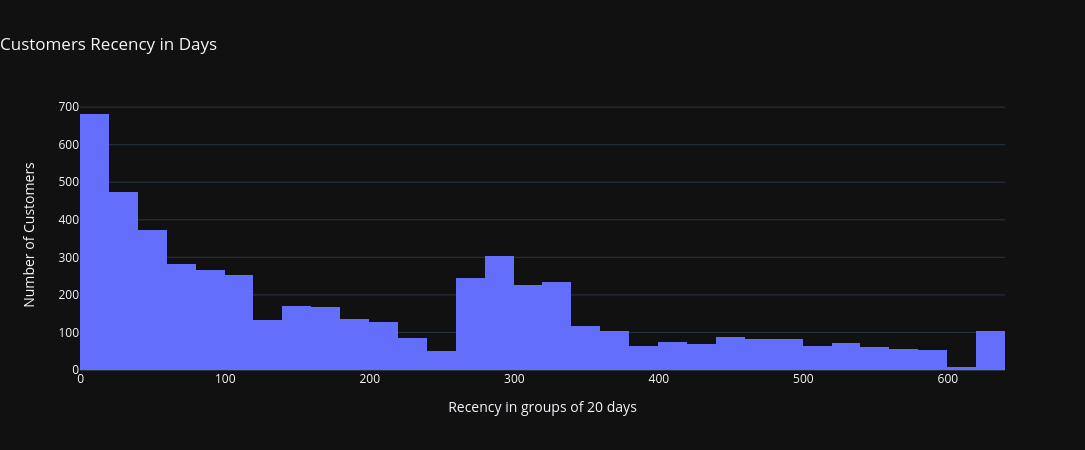

In [34]:
# plot histogram
hist_fig = px.histogram(ctm_dt, 
                        x="Recency", 
                        title="Customers Recency in Days", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recency in groups of 20 days", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

Next we will apply _K-means_ clustering to assign a recency score. However, we need to know how many clusters in order to use the _K-means_ algorithm. We will apply _Elbow Method_ to determine how many clusters we will need. The _Elbow Method_ simply tells the optimal cluster number for optimal inertia.

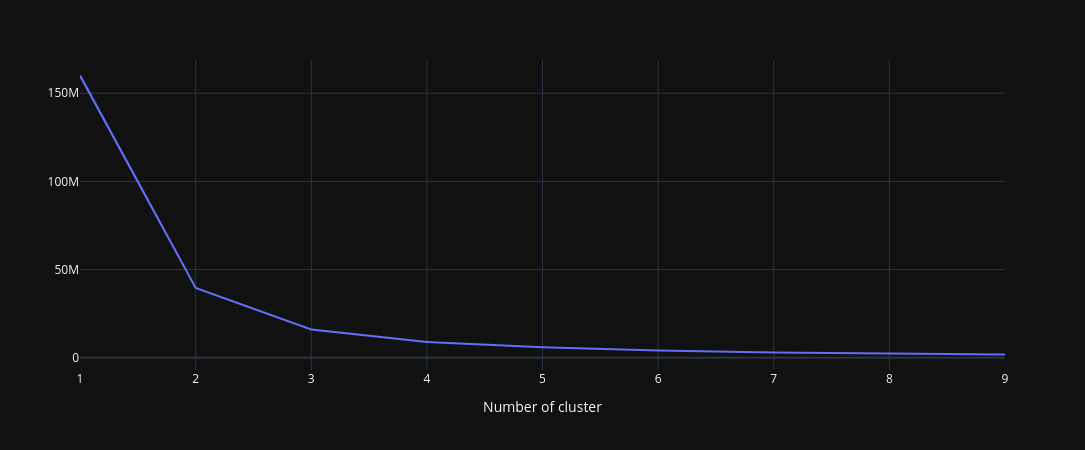

In [35]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

From the Figure above, $4$ seem to be the optimal one.

In [36]:
number_of_clusters = 4

Let's build a $4$ clusters for recency and add it to dataframe, `ctm_dt`.

In [37]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,13085.0,9999.0,57,0
1,13078.0,13.0,0,0
2,15362.0,9999.0,348,1
3,18102.0,27.0,26,0
4,12682.0,15.0,0,0


In [38]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [39]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,13085.0,9999.0,57,3
1,13078.0,13.0,0,3
2,18102.0,27.0,26,3
3,12682.0,15.0,0,3
4,18087.0,46.0,44,3


In [40]:
#print cluster characteristics
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,750.0,520.509333,65.218473,418.0,465.0,517.0,571.5,638.0
1,1427.0,314.360196,41.129298,236.0,281.5,308.0,338.0,416.0
2,1090.0,156.211927,38.996363,98.0,119.0,153.0,187.0,234.0
3,2047.0,38.300440,27.999147,0.0,13.0,33.0,61.0,97.0


Observe from the above that, $3$ covers the most recent customers whereas $0$ has the most inactive customers.

<a id='frequency'></a>
#### Frequency 

Next, we will find customers purchase behaviour based on the number of times they buy from the online retail shop. That is, the total number of orders by each customer.

In [41]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

In [42]:
#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,13085.0,9999.0,57,3,92
1,13078.0,13.0,0,3,855
2,18102.0,27.0,26,3,1068
3,12682.0,15.0,0,3,1042
4,18087.0,46.0,44,3,95


In [43]:
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,5314.000000
mean,149.498495
std,378.177404
min,1.000000
25%,22.000000
50%,59.000000
75%,158.750000
max,13097.000000


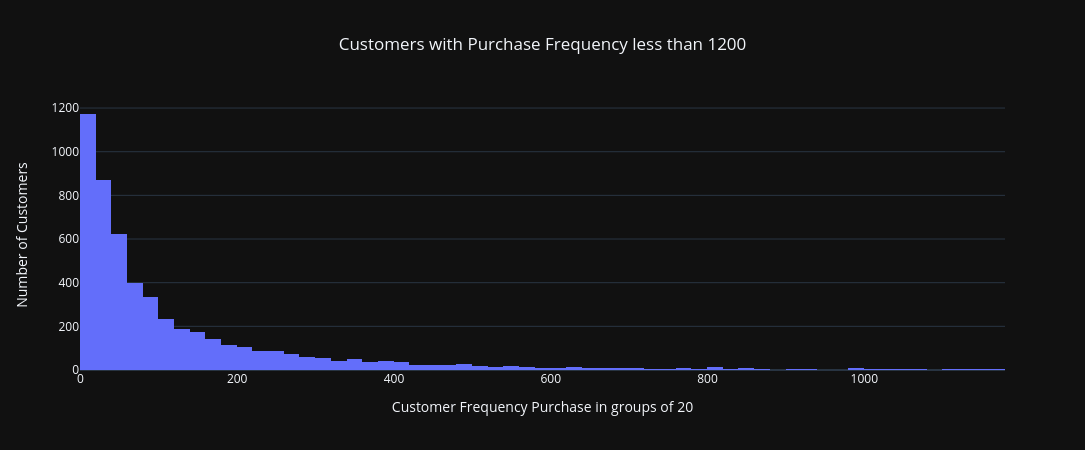

In [44]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Frequency < 1200')['Frequency'], 
                        title="Customers with Purchase Frequency less than 1200", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customer Frequency Purchase in groups of 20", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

In [45]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [46]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,9999.0,57,3,92,3
1,18087.0,46.0,44,3,95,3
2,17519.0,116.0,33,3,224,3
3,12362.0,40.0,12,3,275,3
4,15712.0,38.0,9,3,167,3


In [47]:
#see details of each cluster
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2.0,12355.000000,1049.346463,11613.0,11984.00,12355.0,12726.00,13097.0
1,14.0,3921.000000,1541.056680,2430.0,2829.50,3346.5,4570.25,7307.0
2,404.0,716.732673,318.764750,403.0,482.75,604.0,844.50,2134.0
3,4894.0,86.896404,91.175905,1.0,20.00,51.0,123.00,402.0


As it was for the case of the Recency, higher frequency number means better customers.

<a id='revenue'></a>
#### Revenue

In [48]:
ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

In [49]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085.0,9999.0,57,3,92,3,1459.46
1,18087.0,46.0,44,3,95,3,14411.62
2,17519.0,116.0,33,3,224,3,5102.80
3,12362.0,40.0,12,3,275,3,5284.58
4,15712.0,38.0,9,3,167,3,3467.46


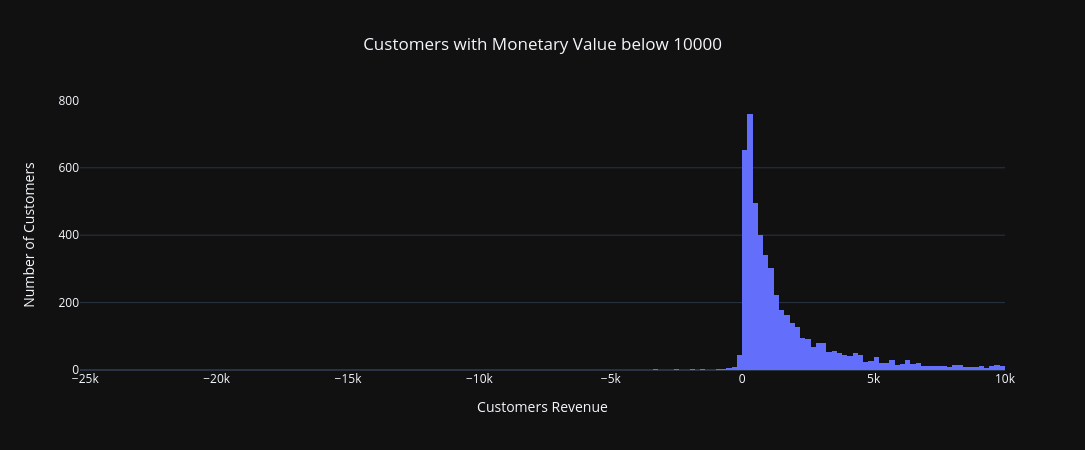

In [50]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Revenue < 10000')['Revenue'], 
                        title="Customers with Monetary Value below 10000", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customers Revenue", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

In [51]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

In [52]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,9999.0,57,3,92,3,1459.46,0
1,18087.0,46.0,44,3,95,3,14411.62,0
2,17519.0,116.0,33,3,224,3,5102.80,0
3,12362.0,40.0,12,3,275,3,5284.58,0
4,15712.0,38.0,9,3,167,3,3467.46,0


In [53]:
#show details of the dataframe
ctm_dt.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5254.0,2094.826057,3318.857554,-25111.09,345.0625,930.5550,2355.6750,26278.86
1,50.0,50516.735860,22611.350789,26626.80,33190.5675,43522.8205,58026.3400,113513.07
2,8.0,198033.391250,62010.602305,136391.48,142827.5300,181355.7500,242746.6750,296564.69
3,2.0,560778.645000,52943.312094,523342.07,542060.3575,560778.6450,579496.9325,598215.22


<a id='overall-score'></a>
#### Overall Score 

Finally we sum all the cluster features

In [54]:
#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
3,514.613281,39.929688,435.112398
4,308.918381,96.774348,1237.672534
5,126.511747,265.383994,3913.308628
6,40.724927,144.641056,3506.303408
7,12.450000,676.900000,109639.778000
8,26.000000,1068.000000,598215.220000


The scoring above clearly shows us that customers with score $8$ are our best customers whereas those who score $3$ are the worst.

In [55]:
ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'

In [56]:
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,Mid-Value
1,18087.0,46.0,44,3,95,3,14411.62,0,6,Mid-Value
2,17519.0,116.0,33,3,224,3,5102.80,0,6,Mid-Value
3,12362.0,40.0,12,3,275,3,5284.58,0,6,Mid-Value
4,15712.0,38.0,9,3,167,3,3467.46,0,6,Mid-Value


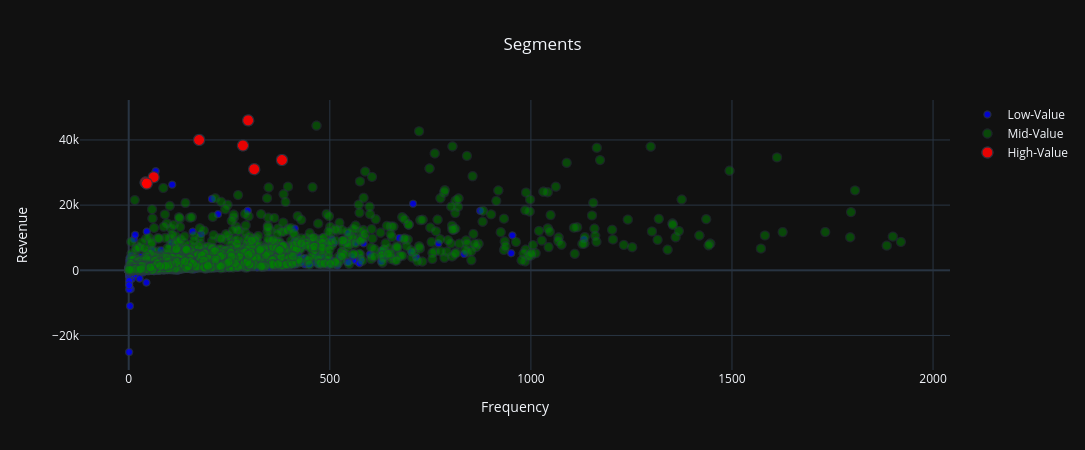

In [57]:
#A scatter plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")


plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})

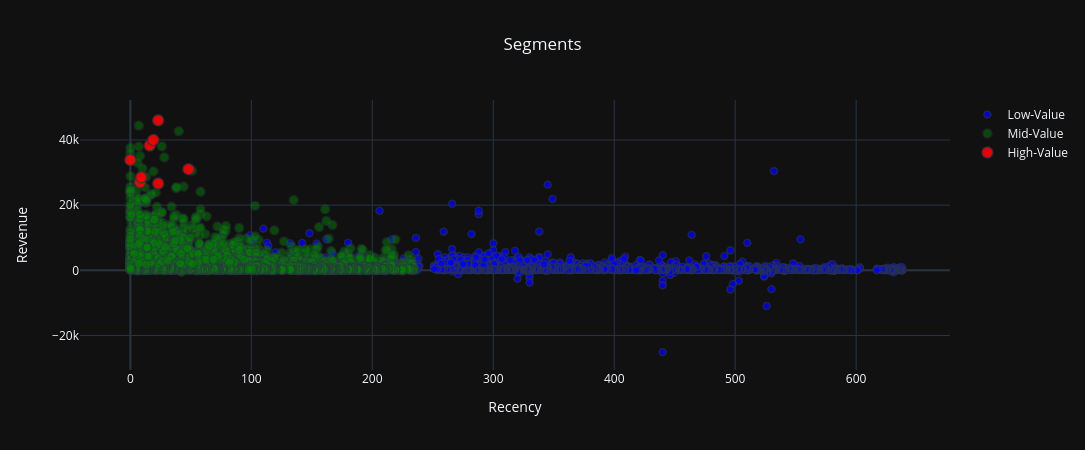

In [58]:
# Scatter Plot of Revenue verses Recency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})

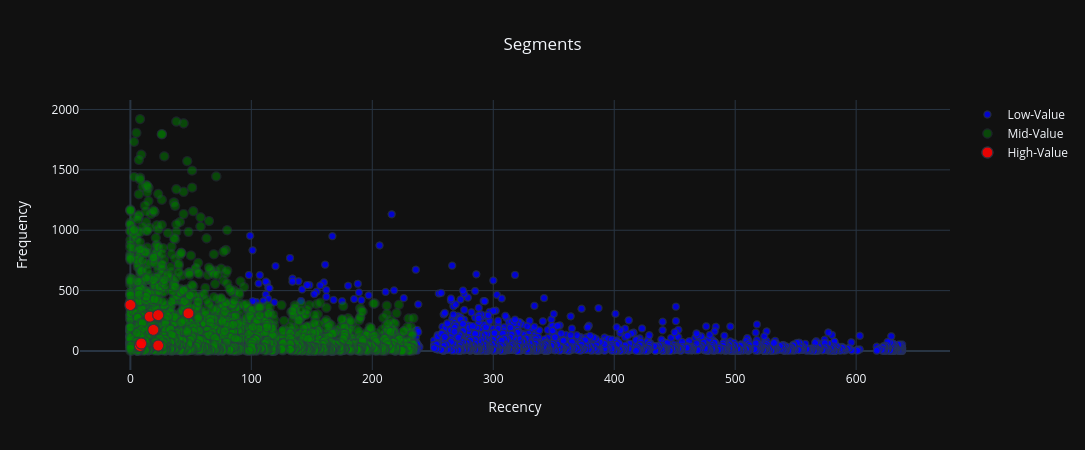

In [59]:
# Scatter Plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low-Value',
        marker= dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5,
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show(config={'displaylogo': False})

Let us create a copy of the dataframe `ctm_dt` and apply the method `get_dummies` to it so as to convert all categorical column `Segment` to indicator variables. 

In [60]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1


Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column `NextPurchaseDayRange` with values as either $1$ or $0$ defined as follows:  
* If the value is $1$, then it indicates that the customer will buy something in the next quarter, i.e., $90$ days from his or her last purchase. 
* The value $0$ indicates that the customer will buy something in more than $90$ days from his or her last purchase.

In [61]:
ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,13085.0,9999.0,57,3,92,3,1459.46,0,6,0,0,1,0
1,18087.0,46.0,44,3,95,3,14411.62,0,6,0,0,1,1
2,17519.0,116.0,33,3,224,3,5102.80,0,6,0,0,1,0
3,12362.0,40.0,12,3,275,3,5284.58,0,6,0,0,1,1
4,15712.0,38.0,9,3,167,3,3467.46,0,6,0,0,1,1


Finally in this section, let's see the correlation between our features and label. We can achieve this by applying the `corr` method to the dataframe `ctm_dt`.

In [62]:
corr_matrix = ctm_class[ctm_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
CustomerID,-0.044414,0.041746
NextPurchaseDay,-0.569494,0.451357
Recency,-0.964632,0.857138
RecencyCluster,-0.964632,0.968014
Frequency,-0.704095,0.476721
FrequencyCluster,-0.704095,0.271931
Revenue,-0.377883,0.826016
RevenueCluster,-0.339724,0.826016
OverallScore,-0.932046,0.968014
Segment_High-Value,-0.075608,0.674895


From the output above, we observe that __Overall Score__ has the highest positive correlation of $0.97$ with __RecencyCluster__ and __Segment_Low-Value__ has the highest negative of -0.99 with __Segment_Mid-Value__. 

We can get a good visualisation of the coefficient matrix below.

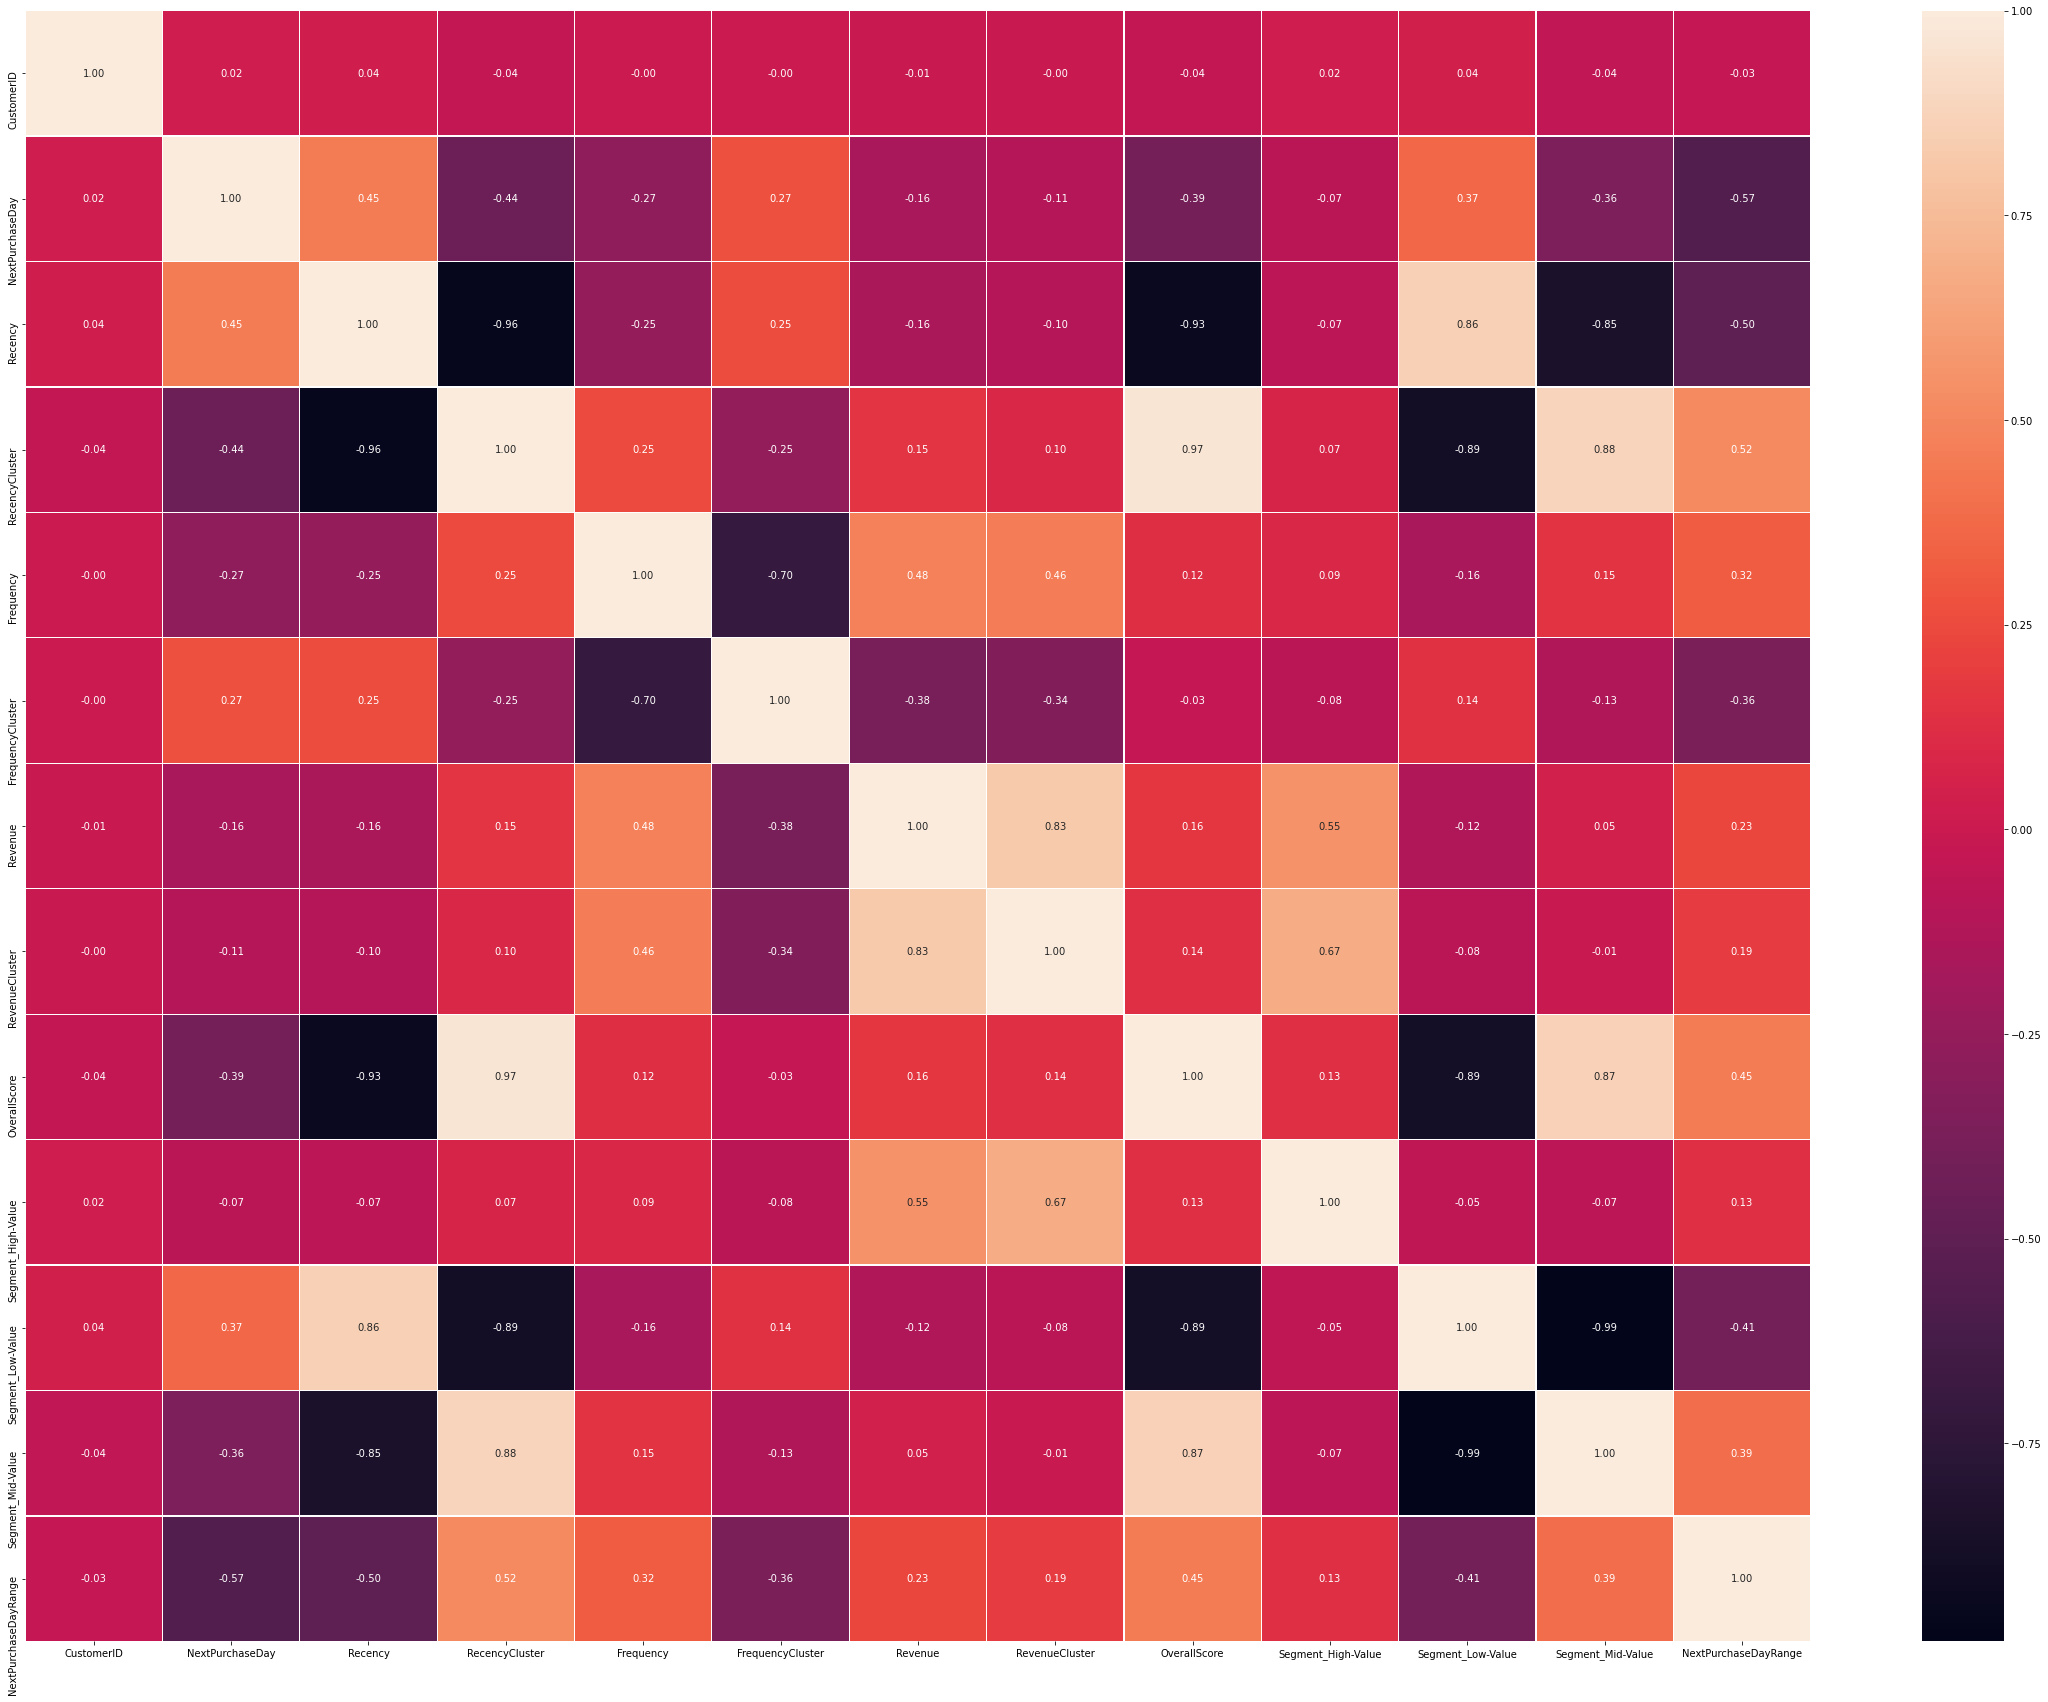

In [63]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

<a id='building-machine-learning-models'></a>
## Building Machine Learning Models

In [64]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)

In [73]:
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [74]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [75]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
LogisticRegression,0.904493,0.845047,0.847697,0.842476,0.079389
RandomForestClassifier,0.892811,0.830562,0.843266,0.833429,0.514627
GaussianNB,0.888265,0.825232,0.842565,0.831182,0.034731
xgb.XGBClassifier,0.883714,0.797605,0.797937,0.823420,0.380879
SVC,0.881617,0.788772,0.790510,0.826198,0.322299
DecisionTreeClassifier,0.881582,0.791953,0.792876,0.822376,0.025069
KNeighborsClassifier,0.878584,0.788108,0.786090,0.813467,0.232109


From this result, we see that `LogisticRegression` is the best in terms of accuracy.

In [76]:
log_reg_model = LogisticRegression().fit(X_train, y_train)
print('Accuracy of LogisticRegression on training set: {:.2f}'.format(log_reg_model.score(X_train, y_train)))
print('Accuracy of LogisticRegression on test set: {:.2f}'.format(log_reg_model.score(X_test[X_train.columns], y_test)))

Accuracy of LogisticRegression on training set: 0.90
Accuracy of LogisticRegression on test set: 0.90


Let's see how we could improve on the accuracy of the existing model `XGB` by finding suitable parameters. We will check if the improved `XGB Classifier` model outperforms the `LogisticRegression`

The `XGB Classifier` model gives us the following:

In [77]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss').fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.89


In [78]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [79]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.9033153671628575)

In [80]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                              max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                              min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                             ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.91


As we can see, the improved `XGB classifier` model is accurate than the `LogisticRegression` model by $0.1$. 

Let us go ahead and predict with these two models.

In [81]:
xgb_pred_y = xgb_model.predict(X_test)

In [82]:
log_reg_pred_y = log_reg_model.predict(X_test)

Let compute the confusion matrices of these two models with the user-defined function `get_confusion_matrix` defined below. 

In [83]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

Let's get the confusion matrix for `y_test` and `xgb_pred_y`, i.e., for the improved `XGB classifier` model and `y_test` and `log_reg_pred_y`, i.e., for the `LogisticRegression` model.

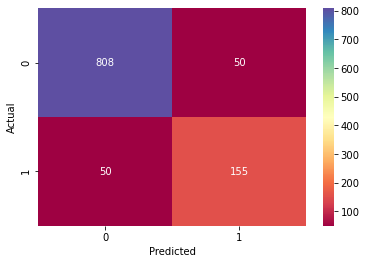

In [84]:
get_confusion_matrix(np.array(y_test), xgb_pred_y)

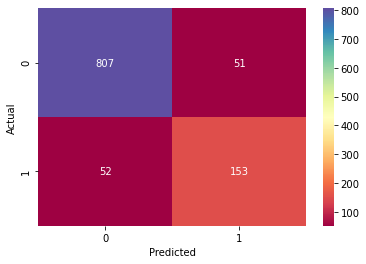

In [85]:
get_confusion_matrix(np.array(y_test), log_reg_pred_y)

In [86]:
xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "LogisticRegression"], 
                    "accuracy"   : [accuracy_score(y_test, xgb_pred_y), accuracy_score(y_test, log_reg_pred_y)], 
                    "f1_score"   : [f1_score(y_test, xgb_pred_y), f1_score(y_test, log_reg_pred_y)], 
                    "recall"     : [recall_score(y_test, xgb_pred_y), recall_score(y_test, log_reg_pred_y)], 
                    "precision"  : [precision_score(y_test, xgb_pred_y), precision_score(y_test, log_reg_pred_y)]
                   }
xgb_log_reg_df = pd.DataFrame(xgb_log_reg_dict).set_index("model_name")
xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)

,accuracy,f1_score,recall,precision
model_name,,,,
xgb.XGBClassifier,0.905927,0.756098,0.756098,0.756098
LogisticRegression,0.903104,0.748166,0.746341,0.750000


It is obvious from the output in the cell above that for each metric, ${\rm accuracy}$, $F_{1}-{\rm score}$, ${\rm recall}$, and ${\rm precision}$, the improved or refined `XGB classifier` model out performs the `LogisticRegression` model. Thus, we will choose the refined `XGB classifier` model over the `LogisticRegression` model. 

<a id='conclusion'></a>
## Conclusion

In summary I observed the following: 

* From the dataset, the online retail shop has 5942 customers from 41 different countries. 

* The top 3 countries are the United Kingdom, Germany and France with the United Kingdom recording the $90.85\%$ of the customers of the online retail shop. 

* The online retail shop made the highest sales in November 2010, followed by November 2011. Also, there was a rise in monthly sales after August. 

* The online retail shop got most of it revenue from customers residing in the United Kingdom followed by The Republic of Ireland, The Netherlands, Germany and France. 

* Finally, we introduced new features into our dataframe, `ctm_dt` and we builded a machine learning model that will help us decide if customer will buy something again from the online shop in the next quarter, i.e., $90$ days from the date of his/her last purchase. Among the models that we used, we had to improve the `XGB classifier` model by the process of hyperparameter tuning to outperform the `LogisticRegression` model. 

* I also communicated the contents of this project [here](https://towardsdatascience.com/using-machine-learning-to-predict-customers-next-purchase-day-7895ad49b4db).